# SOSE SALT BUDGET

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

In [3]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    PHrefC    (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    PHrefF    (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 d

In [4]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 4

## Salt budget for WG (entire water column)

In [5]:
dsr.Z[0]

<xarray.DataArray 'Z' ()>
array(-5., dtype=float32)
Coordinates:
    Z        float32 -5.0
Attributes:
    axis:           Z
    long_name:      vertical coordinate of cell center
    positive:       down
    standard_name:  depth
    units:          m

In [6]:
sss_mean = dsr.SALT.isel(Z=0).mean(dim='time').load()

In [7]:
surface_mask = (coords.hFacC[0]>0).load()

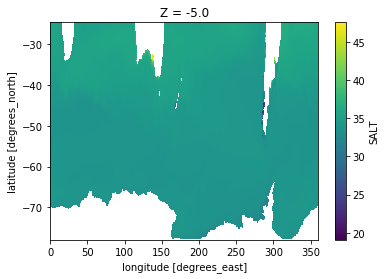

In [8]:
sss_mean.where(surface_mask).plot()

In [9]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat = -78

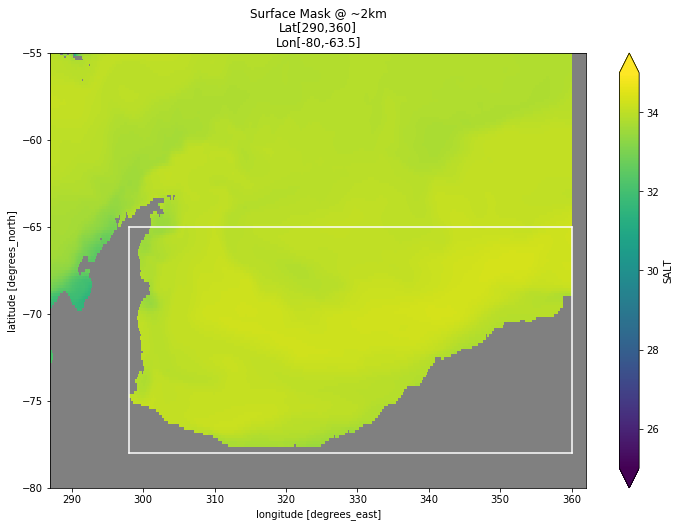

In [10]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sss_mean.where(surface_mask)).plot(ax=ax, vmin=25, vmax=35)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [11]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [12]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [13]:
#advective flux
adv_flux_y = dsr.ADVy_SLT.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_SLT.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ 2.4478822e+08, -3.0404224e+07, -3.3424640e+06,  2.1007808e+07,
       -1.3479872e+07,  1.1151872e+07, -2.6330624e+07,  3.9323264e+07,
       -5.0660864e+07, -3.6309120e+06,  3.3751424e+07, -4.4483200e+06,
        8.5428480e+06, -1.4466688e+07,  2.1769856e+07, -2.4605440e+07,
        1.6070272e+07, -1.5095296e+07,  1.6719616e+07, -1.7666560e+07,
       -3.7056000e+05, -9.5919360e+06, -5.9248000e+06,  3.2604928e+07,
       -1.4586368e+07,  3.7531648e+07,  4.8015360e+06, -2.1849088e+07,
        1.1406080e+07, -9.7748480e+06,  1.3086912e+07, -1.8703232e+07,
       -4.6280320e+06,  3.2925376e+07, -7.3656320e+06, -1.3484928e+07,
       -1.9205760e+07,  3.2585600e+07, -7.7656320e+06,  7.4970240e+06,
       -1.2709120e+06, -1.1798400e+06, -2.2168384e+07,  7.5668480e+06,
       -2.7607296e+07,  1.8284352e+07,  2.1880320e+07, -2.3000704e+07,
        3.0220288e+07,  1.6178432e+07, -2.0243456e+07, -1.5408768e+07,
        1.5550080e+07, -3.6261760e+06,  3.8514

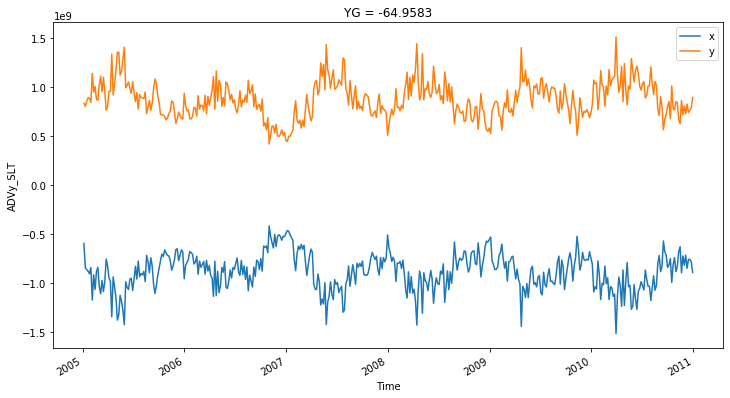

In [14]:
plt.figure(figsize=(12,6))

adv_flux_x.plot(label='x')
adv_flux_y.plot(label='y')
plt.legend()

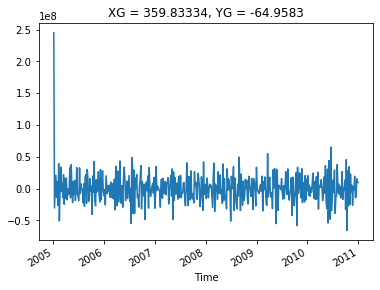

In [15]:
(adv_flux_x+adv_flux_y).plot()

In [16]:
#diffusive flux
diff_flux_y = dsr.DFyE_SLT.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_SLT.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([11423.828  , 13190.536  , 12715.232  , 19115.492  , 19797.115  ,
       13875.574  , 13590.936  , 13477.138  , 11912.361  , 13355.431  ,
       12947.253  , 11972.347  , 13860.763  , 15981.756  , 14561.518  ,
       13385.715  , 13532.603  , 13708.84   , 14308.905  , 14417.975  ,
       11890.238  , 13905.089  , 14007.498  , 11852.117  , 10034.428  ,
       10112.744  , 10680.229  ,  9732.339  ,  9505.5205 , 10110.873  ,
       10504.666  ,  8482.564  ,  8059.5244 ,  8560.668  ,  6595.911  ,
        7581.644  ,  8200.743  ,  8295.638  ,  3820.0923 , 10323.627  ,
        9455.523  , 13792.551  , 14602.527  ,  7462.744  ,  8052.9272 ,
        5564.8267 , -1120.6003 , -2914.6372 ,   170.61523,  7006.676  ,
        8764.654  , 10493.07   , 10804.375  ,  -104.85693, -4522.078  ,
       -4962.5757 , -1893.2175 , -1478.7966 , -1926.867  , -1386.7096 ,
          76.74164,  3063.064  ,  5213.7183 ,  7049.176  ,  7633.9346 ,
        7812.4395 ,  7085.877  , 

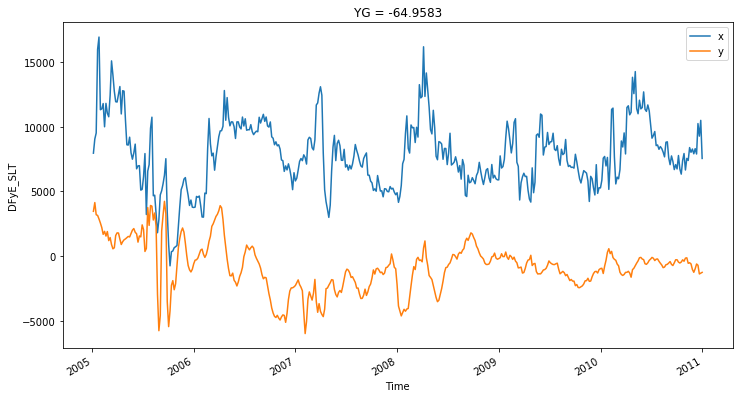

In [17]:
plt.figure(figsize=(12,6))
diff_flux_x.plot(label='x')
diff_flux_y.plot(label='y')
plt.legend()

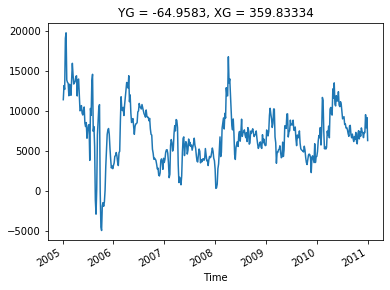

In [18]:
(diff_flux_y+diff_flux_x).plot()

In [19]:
#vertical flux
s_flux_z = (dsr.SFLUX.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
s_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([-1.50914550e+10, -6.02561024e+09, -3.70596147e+09, -2.05715558e+09,
       -1.56814336e+09, -5.53985536e+08,  4.17384928e+08,  5.31087552e+08,
       -1.39375680e+09, -4.98677120e+08,  1.06509376e+09,  4.59405056e+08,
        1.04161882e+09,  1.25834931e+09,  1.52703642e+09,  1.06251136e+09,
        7.66458432e+08,  3.21672640e+08,  8.70126848e+08,  2.17082880e+08,
        1.89559130e+09,  7.32056256e+08,  1.81645146e+09,  1.52919117e+09,
        2.49549414e+09,  3.78110515e+09,  3.26939290e+09,  4.28838579e+09,
        5.07764941e+09,  3.82766387e+09,  2.38556595e+09,  1.39989274e+09,
        2.90007475e+09,  2.74046822e+09,  3.26510746e+09,  3.45263053e+09,
        2.61659034e+09,  2.64613658e+09,  2.83902336e+09,  2.78782669e+09,
        1.82270848e+09,  2.72677171e+09, -1.62087680e+08,  1.30422310e+09,
        7.06274176e+08, -3.99572224e+08, -2.82837120e+08,  1.55973517e+09,
        1.13964083e+09,  1.67757120e+09,  1.29816896e+09,  8.02886336

In [20]:
#linear free surface correction
runit2mass = 1.035e3 #kg/m^3
surface_term = s_flux_z / runit2mass
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WSLTMASS.isel(Zl=0, drop=True) * coords.rA
                     ).isel(**lat_range, **lon_range).sum(dim=['XC', 'YC'])
#i noticed lin_fs_corr term didn't have `**lon_range` - should it not have?
#units: (˚C m^3)/s

In [21]:
surface_term.load()

<xarray.DataArray (time: 438)>
array([-1.45811160e+07, -5.82184550e+06, -3.58063900e+06, -1.98758988e+06,
       -1.51511438e+06, -5.35251750e+05,  4.03270469e+05,  5.13128062e+05,
       -1.34662488e+06, -4.81813656e+05,  1.02907612e+06,  4.43869625e+05,
        1.00639500e+06,  1.21579638e+06,  1.47539750e+06,  1.02658100e+06,
        7.40539562e+05,  3.10794812e+05,  8.40702250e+05,  2.09741906e+05,
        1.83148912e+06,  7.07300750e+05,  1.75502550e+06,  1.47747938e+06,
        2.41110550e+06,  3.65324175e+06,  3.15883375e+06,  4.14336800e+06,
        4.90594150e+06,  3.69822600e+06,  2.30489475e+06,  1.35255338e+06,
        2.80200450e+06,  2.64779550e+06,  3.15469325e+06,  3.33587500e+06,
        2.52810650e+06,  2.55665375e+06,  2.74301775e+06,  2.69355225e+06,
        1.76107100e+06,  2.63456200e+06, -1.56606453e+05,  1.26011900e+06,
        6.82390500e+05, -3.86060125e+05, -2.73272594e+05,  1.50699050e+06,
        1.10110225e+06,  1.62084175e+06,  1.25426950e+06,  7.75735562

In [22]:
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([ 2.3755021e+08, -2.5445118e+07, -3.0695002e+06,  2.0449768e+07,
       -1.1631365e+07,  1.2430527e+07, -2.4738552e+07,  3.8402980e+07,
       -4.7687500e+07, -4.1590250e+05,  3.3330950e+07, -5.1751575e+06,
        8.6790390e+06, -1.5758776e+07,  2.0380848e+07, -2.4292034e+07,
        1.5837228e+07, -1.4787772e+07,  1.5844524e+07, -1.8505878e+07,
       -1.5800675e+06, -9.3555770e+06, -6.3976495e+06,  3.1534210e+07,
       -1.5781024e+07,  3.5337428e+07,  3.0079120e+06, -2.2566848e+07,
        1.0350934e+07, -1.0394415e+07,  1.2749115e+07, -1.8741934e+07,
       -5.0043205e+06,  3.1896874e+07, -7.5145890e+06, -1.4039851e+07,
       -2.0086884e+07,  3.1699362e+07, -8.2549095e+06,  7.1961485e+06,
       -1.3258620e+06, -1.7386435e+06, -2.1944180e+07,  7.3224255e+06,
       -2.7553572e+07,  1.8575766e+07,  2.1734902e+07, -2.2729552e+07,
        3.0254328e+07,  1.6130230e+07, -2.0231382e+07, -1.5574467e+07,
        1.5029934e+07, -3.9317640e+06,  3.8256

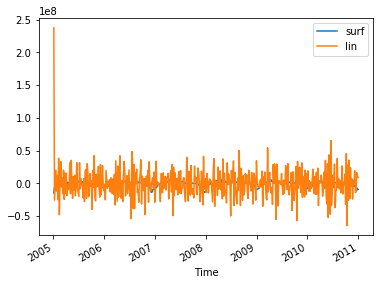

In [23]:
surface_term.plot(label='surf')
lin_fs_correction.plot(label='lin')
plt.legend()

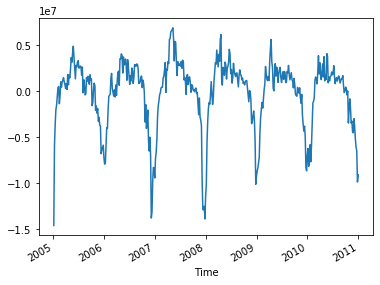

In [27]:
surface_term.plot()

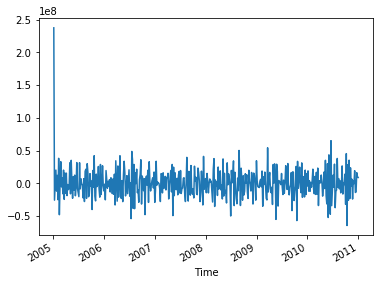

In [28]:
lin_fs_correction.plot()

In [24]:
totstend_weddell = (dsr.TOTSTEND * coords.rA * coords.drF * coords.hFacC).isel(
                            **lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
totstend_weddell.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-2.18305619e+07, -8.75868539e+05, -3.32042657e+06, -2.56477317e+06,
        3.13586607e+05,  7.29547804e+05,  1.98176787e+06, -4.20687834e+05,
        1.61487777e+06,  2.71982061e+06,  5.95655348e+05, -2.94990009e+05,
        1.12872543e+06, -9.22344711e+04,  7.17434548e+04,  1.32658233e+06,
        4.93968640e+05,  6.04720213e+05, -4.85758074e+04, -6.44031147e+05,
        6.10059093e+05,  9.29822341e+05,  1.26808206e+06,  3.94886661e+05,
        1.20644020e+06,  1.44879806e+06,  1.35465311e+06,  3.41572684e+06,
        3.84131755e+06,  3.06843895e+06,  1.95656439e+06,  1.30539814e+06,
        2.41762588e+06,  1.61076300e+06,  2.99909613e+06,  2.77335400e+06,
        1.63875745e+06,  1.66221141e+06,  2.24994342e+06,  2.38232443e+06,
        1.69675454e+06,  2.06198841e+06,  5.29919407e+04,  1.00814952e+06,
        7.28080450e+05, -1.00152569e+05, -4.17501298e+05,  1.78104984e+06,
        1.13506285e+06,  1.56558526e+06,  1.25764162e+06,  5.99566033

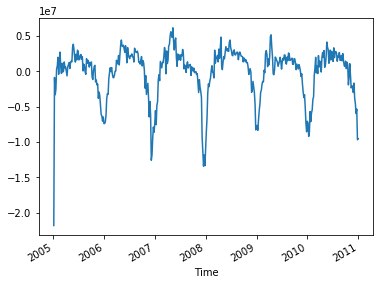

In [29]:
totstend_weddell.plot()

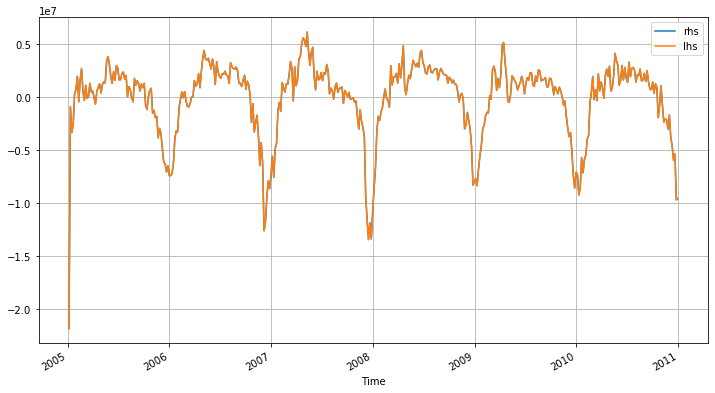

In [25]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = totstend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

In [23]:
all_terms = xr.merge([totstend_weddell.rename('tottend'),
                      -adv_flux.rename('adv_flux'),
                      -diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -64.9583
Data variables:
    tottend    (time) float64 -2.183e+07 -8.759e+05 ... -9.681e+06 -9.557e+06
    adv_flux   (time) float32 -244788220.0 30404224.0 ... -10296448.0 -9591744.0
    diff_flux  (time) float32 -11423.828 -13190.536 ... -9183.003 -6305.7637
    lin_fs     (time) float32 237550200.0 -25445118.0 ... 10479289.0 9101356.0
    surface    (time) float32 -14581116.0 -5821845.5 ... -9854398.0 -9060484.0

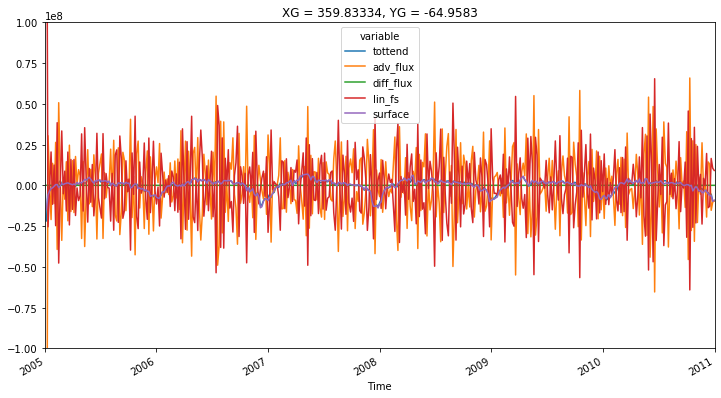

In [24]:
plt.figure(figsize=(12,6))
all_terms.to_array().plot.line(x='time')
plt.xlim('2005', '2011')
plt.ylim(-1e8, 1e8);

In [25]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,-89208.981323
adv_flux,-487758.031250
diff_flux,-7059.955566
lin_fs,509638.125000
surface,-104029.414062


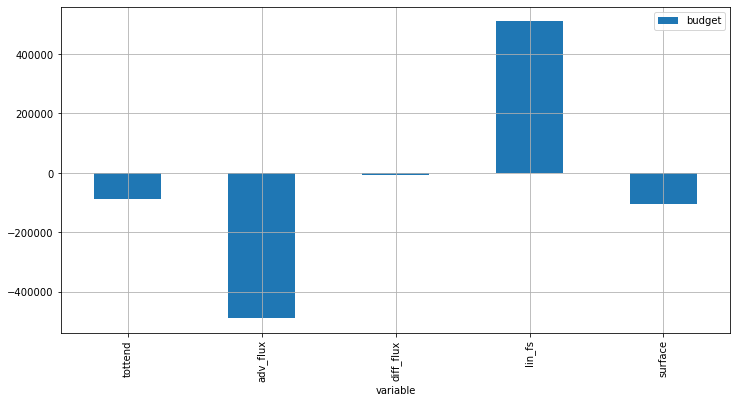

In [26]:
df.plot(figsize=(12,6), kind='bar')
plt.grid();

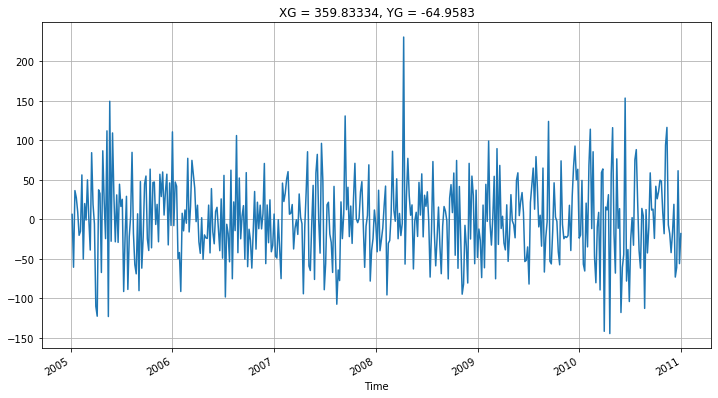

In [27]:
(rhs - lhs).plot(figsize=(12,6))
plt.grid();

In [28]:
adv_flux_clim = (adv_flux.groupby('time.month') 
                    - adv_flux.groupby('time.month').mean(dim='time'))
diff_flux_clim = (diff_flux.groupby('time.month') 
                      - diff_flux.groupby('time.month').mean(dim='time'))
surf_term_clim = (surface_term.groupby('time.month')
                  - surface_term.groupby('time.month').mean(dim='time'))
lin_fs_correction_clim = (lin_fs_correction.groupby('time.month') -
                          lin_fs_correction.groupby('time.month').mean(dim='time'))
totstend_weddell_clim = (totstend_weddell.groupby('time.month') 
                            - totstend_weddell.groupby('time.month').mean(dim='time'))

In [29]:
all_terms_clim = xr.merge([-adv_flux_clim.rename('adv_flux'), 
                            -diff_flux_clim.rename('diff_flux'),
                            surf_term_clim.rename('surf_term'),
                            lin_fs_correction_clim.rename('lin_fs_corr'),
                            totstend_weddell_clim.rename('tottend')])
all_terms_clim

<xarray.Dataset>
Dimensions:      (time: 438)
Coordinates:
    XG           float32 359.83334
    YG           float32 -64.9583
  * time         (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month        (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 12 12 12 12 12 12 12
Data variables:
    adv_flux     (time) float32 -239527900.0 35664544.0 ... -7577281.0
    diff_flux    (time) float32 -4960.196 -6726.904 ... -4074.1035 -1196.8643
    surf_term    (time) float32 -9057883.0 -298612.5 ... -2726808.5 -1932894.5
    lin_fs_corr  (time) float32 232182990.0 -30812340.0 ... 8071871.0 6693938.0
    tottend      (time) float64 -1.641e+07 4.547e+06 ... -2.941e+06 -2.817e+06

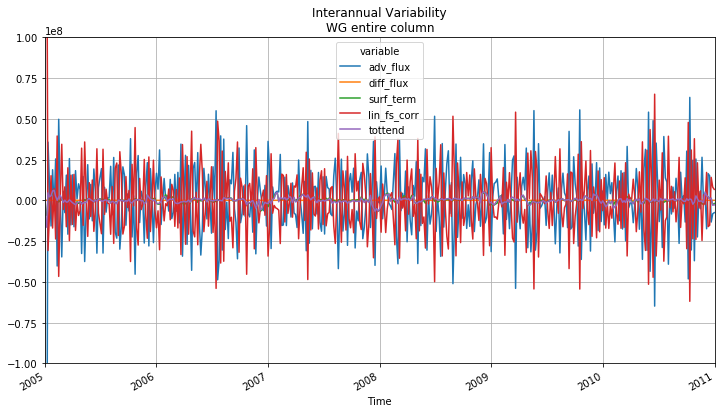

In [30]:
plt.figure(figsize=(12,6))
all_terms_clim.to_array().plot.line(x='time')
plt.grid()
plt.ylim(-1e8, 1e8)
plt.xlim('2005', '2011')
plt.title('Interannual Variability\nWG entire column');

In [31]:
cov_adv = (np.cov(totstend_weddell_clim, -adv_flux_clim) / 
           np.cov(totstend_weddell_clim, totstend_weddell_clim))
cov_diff = (np.cov(totstend_weddell_clim, -diff_flux_clim) / 
            np.cov(totstend_weddell_clim, totstend_weddell_clim))
cov_surf = (np.cov(totstend_weddell_clim, surf_term_clim) / 
            np.cov(totstend_weddell_clim, totstend_weddell_clim))
cov_lin_fs = (np.cov(totstend_weddell_clim, lin_fs_correction_clim) / 
            np.cov(totstend_weddell_clim, totstend_weddell_clim))
cov_totstend = (np.cov(totstend_weddell_clim, totstend_weddell_clim) /
               np.cov(totstend_weddell_clim, totstend_weddell_clim))

In [32]:
cov_array = np.array([cov_adv[1,0], cov_diff[1,0], cov_surf[1,0], cov_lin_fs[1,0], cov_totstend[1,0]])
cov_array

array([ 3.90858059e+00, -1.25309715e-05,  8.29665955e-01, -3.73823450e+00,
        1.00000000e+00])

In [33]:
cov_array_terms = np.array(['adv', 'diff', 'surf', 'lin_fs_corr', 'totstend'])

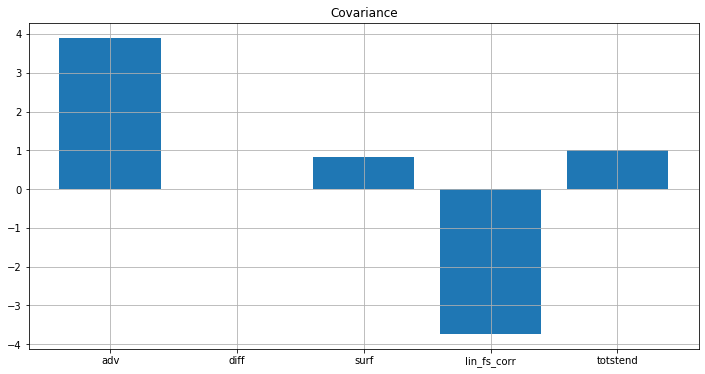

In [34]:
plt.figure(figsize=(12,6))
plt.bar(cov_array_terms, cov_array)
plt.grid()
plt.title('Covariance');

## Salt budget for Lower WG (-2,046m to bottom)

In [35]:
dsr.Z[27]

<xarray.DataArray 'Z' ()>
array(-2046., dtype=float32)
Coordinates:
    Z        float32 -2046.0
Attributes:
    axis:           Z
    long_name:      vertical coordinate of cell center
    positive:       down
    standard_name:  depth
    units:          m

In [36]:
sss_mean_lower = dsr.SALT.isel(Z=27).mean(dim='time').load()

In [37]:
surface_mask_lower = (coords.hFacC.isel(Z=27)>0).load()

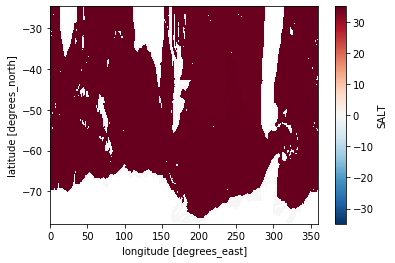

In [38]:
sss_mean_lower.where(surface_mask_lower).plot()

In [39]:
left_lon = 299
upper_lat = -66
right_lon = 360
lower_lat = -78

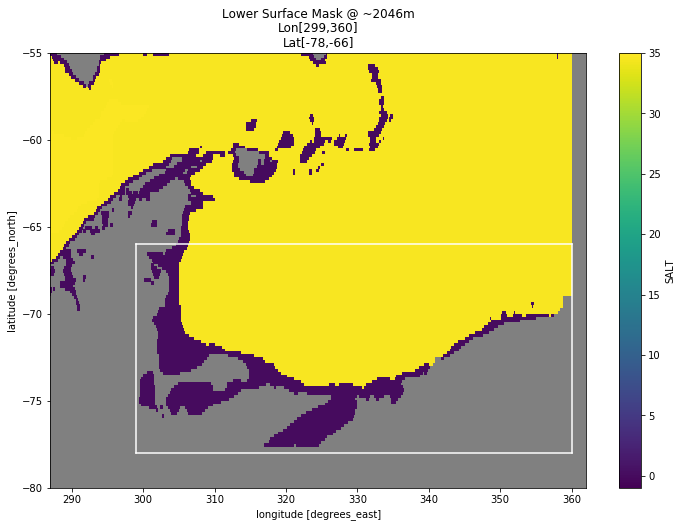

In [40]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sss_mean_lower.where(surface_mask_lower)).plot(ax=ax, vmin=-1, vmax=35)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Lower Surface Mask @ ~2046m\nLon[299,360]\nLat[-78,-66]');

In [41]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [42]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [43]:
#advective flux
adv_flux_y_lower = dsr.ADVy_SLT.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['XC','Z']).load()
adv_flux_x_lower = dsr.ADVx_SLT.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['YC','Z']).load()
adv_flux_z_lower = dsr.ADVr_SLT.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-119824.,  -74128.,  -92656., ..., -122416.,  -61980.,  -94804.],
      dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -66.12497
    Zl       float32 -1904.0

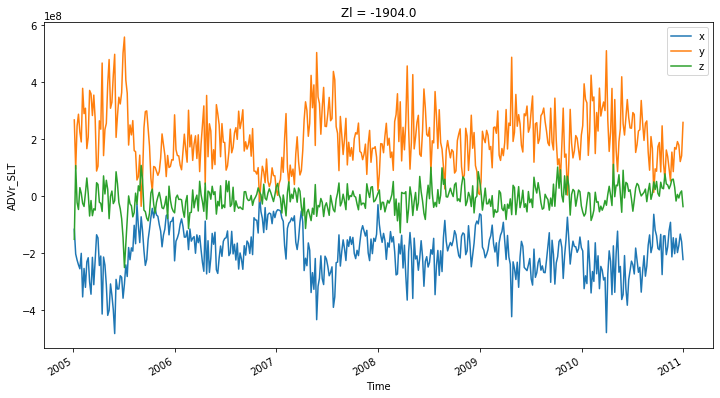

In [44]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [45]:
#diffusive flux
diff_flux_y_lower = dsr.DFyE_SLT.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                 dim=['XC','Z']).load()
diff_flux_x_lower = dsr.DFxE_SLT.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                 dim=['YC','Z']).load()
diff_flux_z_lower =  ((dsr.DFrE_SLT.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + dsr.DFrI_SLT.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + dsr.KPPg_SLT.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                                                                                                  ).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ 3.578557e+05, -1.895548e+03, -2.549492e+03, ...,  7.791396e+01,
        3.105708e+02,  3.735557e+02], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -66.12497
    Zl       float32 -1904.0

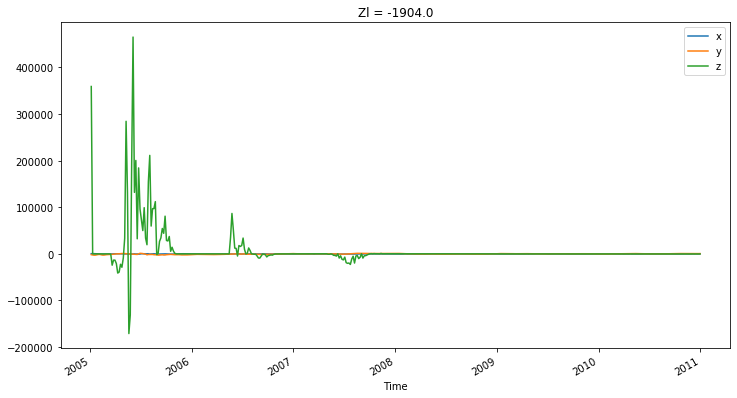

In [46]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [47]:
totstend_weddell_lower = ((dsr.TOTSTEND * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                   dim=['XC', 'YC','Z']))/ (24*60*60)
totstend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-238043.188148,   75993.167407,   95222.820741, ...,  122356.02963 ,
         61669.226667,   94413.594074])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

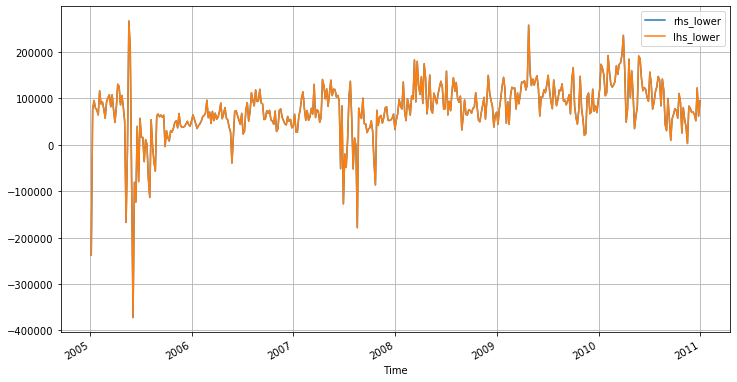

In [48]:
plt.figure(figsize=(12,6))
rhs_lower = -adv_flux_lower - diff_flux_lower
lhs_lower = totstend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();

In [49]:
all_terms_lower = xr.merge([adv_flux_lower.rename('adv_flux'), 
                            diff_flux_lower.rename('diff_flux'),
                            totstend_weddell_lower.rename('totstend')])
all_terms_lower

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
    XG         float32 359.83334
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG         float32 -66.12497
    Zl         float32 -1904.0
Data variables:
    adv_flux   (time) float32 -119824.0 -74128.0 -92656.0 ... -61980.0 -94804.0
    diff_flux  (time) float32 357855.66 -1895.5476 ... 310.57077 373.55566
    totstend   (time) float64 -2.38e+05 7.599e+04 ... 6.167e+04 9.441e+04

In [50]:
df_lower = all_terms_lower.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df_lower

,budget
variable,
adv_flux,-82286.648438
diff_flux,6337.424316
totstend,75949.178394


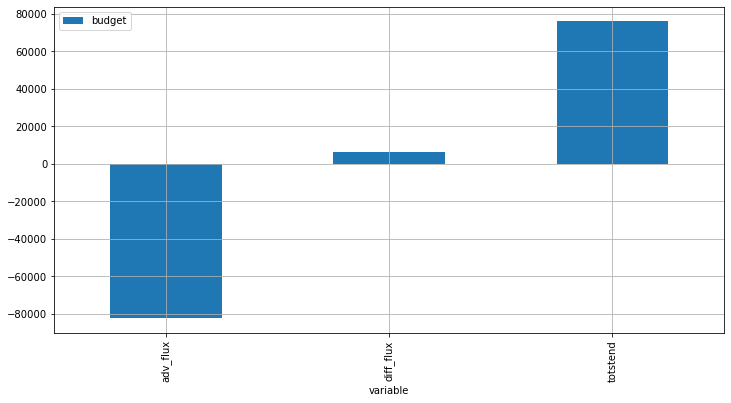

In [51]:
df_lower.plot(figsize=(12,6), kind='bar')
plt.grid()

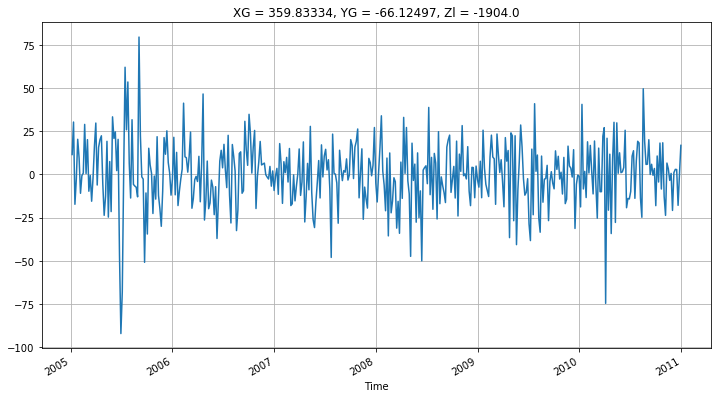

In [52]:
(rhs_lower - lhs_lower).plot(figsize=(12,6))
plt.grid();

In [53]:
adv_flux_lower_clim = (adv_flux_lower.groupby('time.month') 
                    - adv_flux_lower.groupby('time.month').mean(dim='time'))
diff_flux_lower_clim = (diff_flux_lower.groupby('time.month') 
                      - diff_flux_lower.groupby('time.month').mean(dim='time'))
totstend_weddell_lower_clim = (totstend_weddell_lower.groupby('time.month') 
                            - totstend_weddell_lower.groupby('time.month').mean(dim='time'))

In [54]:
all_terms_lower_clim = xr.merge([adv_flux_lower_clim.rename('adv_flux'), 
                            diff_flux_lower_clim.rename('diff_flux'),
                            totstend_weddell_lower_clim.rename('tottend')])
all_terms_lower_clim

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
    XG         float32 359.83334
    YG         float32 -66.12497
    Zl         float32 -1904.0
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month      (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 12 12 12 12 12 12 12
Data variables:
    adv_flux   (time) float32 -37527.797 8168.203 ... 5251.7344 -27572.266
    diff_flux  (time) float32 349200.2 -10551.013 ... 595.3148 658.29974
    tottend    (time) float64 -3.117e+05 2.355e+03 ... -5.847e+03 2.69e+04

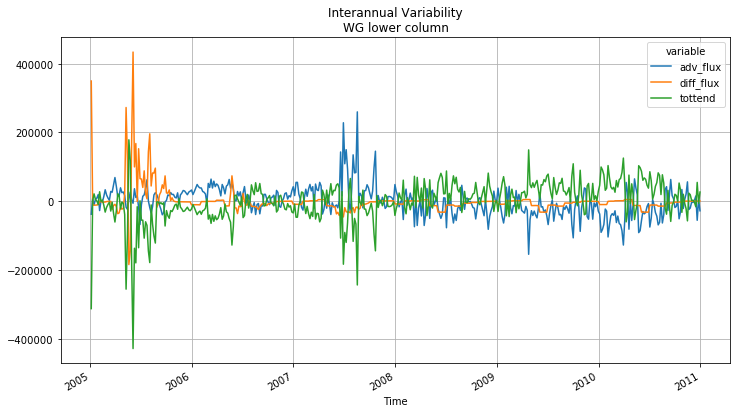

In [55]:
plt.figure(figsize=(12,6))
all_terms_lower_clim.to_array().plot.line(x='time')
plt.grid()
plt.title('Interannual Variability\nWG lower column');

In [56]:
cov_adv_lower = (np.cov(totstend_weddell_lower_clim, -adv_flux_lower_clim) / 
           np.cov(totstend_weddell_lower_clim, totstend_weddell_lower_clim))
cov_diff_lower = (np.cov(totstend_weddell_clim, -diff_flux_lower_clim) / 
            np.cov(totstend_weddell_lower_clim, totstend_weddell_lower_clim))
cov_totstend_lower = (np.cov(totstend_weddell_lower_clim, totstend_weddell_lower_clim) /
               np.cov(totstend_weddell_lower_clim, totstend_weddell_lower_clim))

In [57]:
cov_adv_lower

array([[1.        , 0.51541281],
       [0.51541281, 0.54380758]])

In [58]:
cov_diff_lower

array([[1.11623758e+03, 5.25897292e+00],
       [5.25897292e+00, 5.12968549e-01]])

In [59]:
cov_totstend_lower

array([[1., 1.],
       [1., 1.]])

In [60]:
cov_array_lower = np.array([cov_adv_lower[1,0], cov_diff_lower[1,0], cov_totstend_lower[1,0]])
cov_array_lower

array([0.51541281, 5.25897292, 1.        ])

In [61]:
cov_array_terms_lower = np.array(['adv_lower', 'diff_lower', 'totstend_lower'])

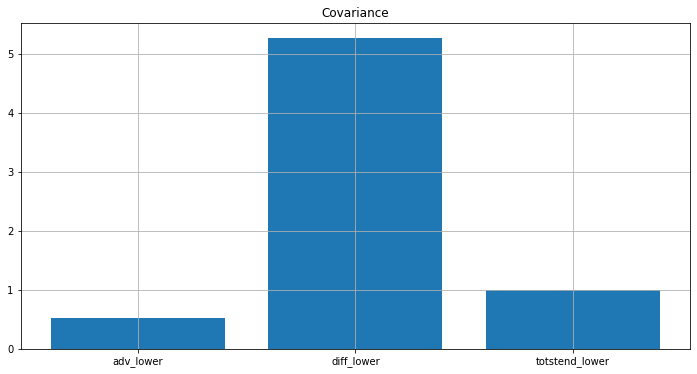

In [62]:
plt.figure(figsize=(12,6))
plt.bar(cov_array_terms_lower, cov_array_lower)
plt.grid()
plt.title('Covariance');